In [170]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt

In [171]:
# Parámetros
sourceDataFolder = "1-source-data"

bumeraniterationNumber = "4"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

linkediniterationNumber = "2"
linkedinRootPath = sourceDataFolder + r"\main\linkedin\iteration-" + linkediniterationNumber

intermFilesFolder = "2-intermediate-files"
mergedMainFolder = "3-results"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [172]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Experiencia laboral", "Educación", "Informática", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [173]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-source-data\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html"
    #r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(24).html"
    # 5 casos con estudios en blanco
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(173).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html",
    #r"1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    # 3 archivos con data incompleta
    r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
    r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html",
    r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
    
  ]
  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = None
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [174]:
def getEncodingBumeran(file, stringLog):
  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [175]:
def getEncodingLinkedin(file, stringLog):
  encoding = "windows-1256"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1256") as f:
        if "charset=windows-1256" in f.read():
          encoding = 'windows-1256'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [176]:
def getCandidateBumeran(file, encoding, stringLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      # Nombre del postulante
      rawcandidateName = soup.find_all("ul", {"type": "disc"})[0].find_all("span")[0].text # El split join tambien quita saltos de línea
      candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(rawcandidateName))

      # Pais de residencia
      tagResidenceCountry = soup.find_all("ul", {"type": "disc"})[0].find_all("span")
      if len(tagResidenceCountry) > 2:
        if tagResidenceCountry[2].text.find(",") != -1:
          residenceCountry = parseNames(parseLineBreaksAndAccents(tagResidenceCountry[2].text[0:tagResidenceCountry[2].text.find(",")]))
          if residenceCountry != "":
            candidateData["residenceCountry"] = residenceCountry
          else:
            raise Exception("Error no mapeado 1")
        else:
          # Intentando sacarlo del pais de nacimiento
          if tagResidenceCountry[8].text.find(",") != -1:
            residenceCountry = parseNames(parseLineBreaksAndAccents(tagResidenceCountry[8].text[tagResidenceCountry[8].text.rfind(",")+2:]))
            if residenceCountry != "":
              candidateData["residenceCountry"] = residenceCountry
            else:
              raise Exception("Error no mapeado 3")
          else:
            # Analizar si permitir o no
            raise Exception("Error no mapeado 2")
      else:
        raise Exception("Error no mapeado 4 (posiblemente data incompleta como los 3 casos)")
      
      
      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)

      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)
      
      # Experiencia laboral
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[0].find_all("b")[0].text))
        candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[1].find_all("b")[0].text))

        daysOfExperience = 0
        for index in range(0, len(workExperienceTags), 2):
          startDate = datetime.datetime.strptime(parseLineBreaksAndAccents(workExperienceTags[index].text)[0: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")] , "%d-%m-%Y")
          endDateText = parseLineBreaksAndAccents(workExperienceTags[index].text)[parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")+3: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" | ")]
          endDate = datetime.datetime.strptime(endDateText, "%d-%m-%Y") if endDateText != "Presente" else datetime.datetime.strptime(rawPostulationDate, "%A, %B %d, %Y %I:%M %p")
          daysOfExperience = daysOfExperience + (endDate - startDate).days
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)
      else:
        raise Exception("561 errores mapeados (no tienen experiencia laboral)")
      
      
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]
        
        careerTags0 = educationTags[0].find_all("b")
        candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
        candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))

        careerTags1 = educationTags[1].find_all("span")
        tempText = careerTags1[1].text
        candidateData["careerStatus"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.find(",")+2:tempText.rfind(",")]))
        candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.rfind(",")+2:tempText.rfind(".")]))
        candidateData["studiesNumber"] = int(len(educationTags)/2)
      else:
        raise Exception("121 errores mapeados (no tienen educación)")

      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        technicalSkillsTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["technicalSkills"] = int(len(technicalSkillsTags)/4)
      else:
        candidateData["technicalSkills"] = 0

      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        languagesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["languages"] = int(len(languagesTags)/7)
      else:
        candidateData["languages"] = 1

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        otherKnowledgesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["anotherSkills"] = int(len(otherKnowledgesTags)/3)
      else:
        candidateData["anotherSkills"] = 0

      # Pendiente de analizar casos fraccionarios (se trunco para caso práctico)

      # Salario pretendido
      tagsSalary = [index for index, tag in enumerate(soup.find_all("span")) if "Sueldo pretendido" in tag.text]
      if len(tagsSalary) > 0:
        rawSalary = soup.find_all("span")[tagsSalary[0]+1].text
        candidateData["salary"] = int(rawSalary[rawSalary.find("$")+1:rawSalary.find(".")])
      else:
        raise Exception("Errores no mapeados (no tienen salario)")

  except Exception as e:
    candidateData = {}
    print(file)
    stringLog = stringLog + str(file) + "\n"
    traceback.print_exc()
    stringLog = stringLog + traceback.format_exc() + "\n"
    print()
    stringLog = stringLog + "\n"
    pass

  return candidateData, stringLog

In [177]:
def getCandidateLinkedin(file, encoding, stringLog):
  candidateData = {}

  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      
      soup = BeautifulSoup(myFile.read(), "lxml")

      spanBlack = soup.find_all("span", {"style": "color:black"})
      if len(spanBlack) > 4:
        postulationDate = datetime.datetime.strptime(spanBlack[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanBlack2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        postulationDate = datetime.datetime.strptime(spanBlack2[3].text, "%A, %B %d, %Y %I:%M %p")

      # Cambiar el lugar de donde se saca, sacarlo del body no del asunto
      if len(spanBlack) > 7:
        rawProfileName = parseLineBreaksAndAccents(spanBlack[7].text)
      else:
        spanBlack2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawProfileName = parseLineBreaksAndAccents(spanBlack2[7].text)

      startIndexProfileName = rawProfileName.find(": ")
      endIndexProfileName = rawProfileName.find(" from ")

      if postulationDate <= datetime.datetime(2022,9,23,2,15,0):
        
        candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

        candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(rawProfileName[startIndexProfileName+1:endIndexProfileName]))

        candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(soup.find("span", {"style": "font-size:10.5pt;color:#262626;text-decoration:none;\n            text-underline:none"}).text))

        tempSpanTags = soup.find_all("span", {"style": 'font-size:9.0pt;font-family:\n            "Helvetica",sans-serif;color:#737373'})
        existsCountry = True if len(tempSpanTags) > 1 else False
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(tempSpanTags[len(tempSpanTags)-1].text)) if existsCountry else ""

        candidateData["channel"] = "Linkedin"

        tableTags = soup.find_all("table")

        notHaveScreening = True if "Screening qualifications" not in str(soup) else False
        startTag = 15 if notHaveScreening else 16
        endTag = len(tableTags)-3
        findedTableTags = tableTags[startTag:endTag]

        haveTags = [None, None, None, None, None]

        for index, tag in enumerate(findedTableTags):
          haveTags[0] = index if "Current experience" in tag.text else haveTags[0]
          haveTags[1] = index if "Past experience" in tag.text else haveTags[1]
          haveTags[2] = index if "Education" in tag.text else haveTags[2]
          haveTags[3] = index if "Skills matching your job" in tag.text else haveTags[3]
          haveTags[4] = index if "Highlight" in tag.text else haveTags[4]

        for index, haveTag in enumerate(haveTags):
          if index == 0:
            if haveTag is not None:
              #spanTags = findedTableTags[haveTag].find_all("tr")[1].find_all("span") Caso particular que no vale la pena
              #startSpanIndex = 0 if len(spanTags) == 2 else len(spanTags)-3
              candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[1])
              candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[0])
            else:
              candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
          
          elif index == 1:
            if haveTag is not None:
              daysOfExperience = 0
              trTag = findedTableTags[haveTag].find_all("tr")[1]
              pTags = trTag.find_all("p")
              for pTag in pTags:
                spanTag = parseLineBreaksAndAccents(pTag.find_all("span")[1].text)
                startDate = datetime.datetime.strptime(spanTag.split(" - ")[0], "%Y")
                endDate = datetime.datetime.strptime(spanTag.split(" - ")[1], "%Y")
                daysOfExperience = daysOfExperience + (endDate - startDate).days
              candidateData["yearsOfExperience"] = int(daysOfExperience/365)
              candidateData["worksNumber"] = int(len(pTags))
            else:
              candidateData["yearsOfExperience"] = 0
              candidateData["worksNumber"] = 0

          elif index == 2:
            # No se tiene el careerStatus en linkedin
            if haveTag is not None:
              trTags = findedTableTags[haveTag].find_all("tr")[1:]
              #print(trTags[0])
              firstCenterWithDateIndex = -1
              studiesNumber = 0
              for index, trTag in enumerate(trTags):
                if(len(trTag.find_all("span"))>1):
                  if(len(trTags[index-1].find_all("span")) == 1):
                    if firstCenterWithDateIndex == -1:
                      firstCenterWithDateIndex = index-1
                if(len(trTag.find_all("span"))==1):
                  studiesNumber = studiesNumber + 1
              
              #print(firstCenterWithDateIndex)
              #print(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", ")[1])
              #print(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", "))
              #print(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", ")[1]))

              if firstCenterWithDateIndex != -1:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex].text))
                tempTagArray = trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")
                candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")[1])) if len(tempTagArray) > 1 else ""
                candidateData["careerStatus"] = "En Curso" if ("Present" in parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[1].text)) else "Graduado"
                tempText = parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")[0])
                candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText)) if not tempText[0:4].isnumeric() else ""
              else:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[0].text))
                candidateData["careerField"] = ""
                candidateData["careerStatus"] = ""
                candidateData["careerDegree"] = ""
              
              candidateData["studiesNumber"] = studiesNumber
            else:
              candidateData["studyCenter"] = ""
              candidateData["careerField"] = ""
              candidateData["careerStatus"] = ""
              candidateData["careerDegree"] = ""
              candidateData["studiesNumber"] = 0
          elif index == 3:
            if haveTag is not None:
              skillsCounter = 0
              spanTags = findedTableTags[haveTag].find_all("tr")[1].find_all("span")
              for spanTag in spanTags:
                if "".join(spanTag["style"].split()) == 'font-size:10.5pt;font-family:"Helvetica",sans-serif;mso-fareast-font-family:"TimesNewRoman";color:#4D4D4D':
                  skillsCounter = skillsCounter + 1
              
              candidateData["technicalSkills"] = skillsCounter
            else:
              candidateData["technicalSkills"] = 0
            
            candidateData["languages"] = 1
            candidateData["anotherSkills"] = 0 if notHaveScreening else int(parseLineBreaksAndAccents(soup.find_all("table")[10].text)[parseLineBreaksAndAccents(soup.find_all("table")[10].text).find(": ")+2: parseLineBreaksAndAccents(soup.find_all("table")[10].text).find("/")])
          elif index == 4:
            if haveTag is not None:
              highlightText = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)
              isKnows = True if ("knows" in highlightText) else False
              #print(isKnows)
              isMoreThanTwo = True if ("others" in highlightText) else False
              if isKnows and isMoreThanTwo:
                candidateData["references"] = int(highlightText[highlightText.find(" and ")+5:highlightText.find(" others ")])
              elif isKnows and not isMoreThanTwo:
                candidateData["references"] = int(highlightText.count(" and ") + 1)
              else:
                candidateData["references"] = int(highlightText[highlightText.find(" hired ")+7:highlightText.find(" people ")])
            else:
              candidateData["references"] = 0
        candidateData["salary"] = 0
        
      else:
        candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

        candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(rawProfileName[startIndexProfileName+1:endIndexProfileName]))

        candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(soup.find("span", {"style": "color:#0A66C2;text-decoration:none;text-underline:none"}).text))
        
        tempSpanTags = soup.find_all("span", {"style": 'font-size:10.5pt;font-family:"Helvetica",sans-serif;\n          color:#737373'})
        existsCountry = True if len(tempSpanTags) > 1 else False
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(tempSpanTags[len(tempSpanTags)-1].text)) if existsCountry else ""

        candidateData["channel"] = "Linkedin"

        tableTags = soup.find_all("table")

        startTag = 14
        endTag = len(tableTags)-3
        findedTableTags = tableTags[startTag:endTag]

        haveTags = [None, None, None, None, None]

        for index, tag in enumerate(findedTableTags):
          haveTags[0] = index if "Current experience" in tag.text else haveTags[0]
          haveTags[1] = index if "Past experience" in tag.text else haveTags[1]
          haveTags[2] = index if "Education" in tag.text else haveTags[2]
          haveTags[3] = index if "Screening qualifications" in tag.text else haveTags[3]
          haveTags[4] = index if "Highlight" in tag.text else haveTags[4]
        
        for index, haveTag in enumerate(haveTags):
          if index == 0:
            if haveTag is not None:
              tempTrTags = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")
              #print(tempTrTags[1].find_all("span")[0].text)
              tempWorkCenter = tempTrTags[1] if len(tempTrTags) > 1 else ""
              candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(tempWorkCenter[0:tempWorkCenter.rfind(" - ")-4])) if tempWorkCenter != "" else ""
              candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[0])
            else:
              candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
          
          elif index == 1:
            if haveTag is not None:
              daysOfExperience = 0
              trTags = [x for x in findedTableTags[haveTag].find_all("tr") if x.find("span", {"style": 'font-size:9.0pt;font-family:"Helvetica",sans-serif;\n          color:#737373'})]
              #print(trTags)
              for trTag in trTags:
                #print(pTag.text)
                spanTag = parseLineBreaksAndAccents(trTag.find_all("span")[0].text)
                #print(spanTag)
                #print("".isnumeric())
                if spanTag[spanTag.rfind(" - ")-4:spanTag.rfind(" - ")].isnumeric() and spanTag[spanTag.rfind(" - ")+3:spanTag.rfind(" - ")+7].isnumeric():
                  startDate = datetime.datetime.strptime(spanTag[spanTag.rfind(" - ")-4:spanTag.rfind(" - ")], "%Y")
                  endDate = datetime.datetime.strptime(spanTag[spanTag.rfind(" - ")+3:spanTag.rfind(" - ")+7], "%Y")
                  daysOfExperience = daysOfExperience + (endDate - startDate).days
              candidateData["yearsOfExperience"] = int(daysOfExperience/365)
              candidateData["worksNumber"] = int(len(trTags))
            else:
              candidateData["yearsOfExperience"] = 0
              candidateData["worksNumber"] = 0

          elif index == 2:
            # No se tiene el careerStatus en linkedin
            if haveTag is not None:
              trTags = findedTableTags[haveTag].find_all("tr")[1:]
              #print(trTags[0])
              firstCenterWithDateIndex = -1
              studiesNumber = 0
              for index, trTag in enumerate(trTags):
                if " - " in parseLineBreaksAndAccents(trTag.text):
                  if " - " not in parseLineBreaksAndAccents(trTags[index-1].text):
                    if firstCenterWithDateIndex == -1:
                      firstCenterWithDateIndex = index-1
                if(" - " not in parseLineBreaksAndAccents(trTag.text)):
                  studiesNumber = studiesNumber + 1
              #print(firstCenterWithDateIndex)
              if firstCenterWithDateIndex != -1:
                #print("GA")
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex].text))
                tempTagArray = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find("span").text))
                candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(tempTagArray[tempTagArray.find(", ")+1:tempTagArray.rfind(" - ")-4]))
                candidateData["careerStatus"] = "En Curso" if ("Present" in tempTagArray) else "Graduado"
                candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempTagArray[0:tempTagArray.find(", ")])) if tempTagArray.find(", ") != -1 else ""
                #print(candidateData)
              else:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[0].text))
                candidateData["careerField"] = ""
                candidateData["careerStatus"] = ""
                candidateData["careerDegree"] = ""
              
              candidateData["studiesNumber"] = studiesNumber
            else:
              candidateData["studyCenter"] = ""
              candidateData["careerField"] = ""
              candidateData["careerStatus"] = ""
              candidateData["careerDegree"] = ""
              candidateData["studiesNumber"] = 0
          
          elif index == 3:
            if haveTag is not None:
              candidateData["technicalSkills"] = 0
              candidateData["languages"] = 1
              candidateData["anotherSkills"] = int(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)[0])
            else:
              candidateData["technicalSkills"] = 0
              candidateData["languages"] = 1
              candidateData["anotherSkills"] = 0
            
          elif index == 4:
            if haveTag is not None:
              highlightText = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)
              #print(highlightText)
              isKnows = True if ("knows" in highlightText) else False
              #print(isKnows)
              isMoreThanTwo = True if ("others" in highlightText) else False
              if isKnows and isMoreThanTwo:
                candidateData["references"] = int(highlightText[highlightText.find(" and ")+5:highlightText.find(" others ")])
              elif isKnows and not isMoreThanTwo:
                candidateData["references"] = int(highlightText.count(" and ") + 1)
              else:
                candidateData["references"] = int(highlightText[highlightText.find(" hired ")+7:highlightText.find(" people ")])
            else:
              candidateData["references"] = 0
        candidateData["salary"] = 0
      
  except Exception as e:
    candidateData = {}
    print(file)
    stringLog = stringLog + str(file) + "\n"
    traceback.print_exc()
    stringLog = stringLog + traceback.format_exc() + "\n"
    print()
    stringLog = stringLog + "\n"
    pass
  
  return candidateData, stringLog

In [178]:
def iterateFiles(files, source):
  # Definiendo el log de errores
  stringLog = ""

  # Definiendo la data final de candidatos
  data = []
  
  # Iterando por cada archivo
  for file in files:
    # Obteniendo el encoding por cada archivo
    encoding, stringLog = getEncodingBumeran(file, stringLog) if source == 'bumeran' else getEncodingLinkedin(file, stringLog)

    # Obteniendo los datos por cada archivo
    candidate, stringLog = getCandidateBumeran(file, encoding, stringLog) if source == 'bumeran' else getCandidateLinkedin(file, encoding, stringLog)
    
    # Añadiendo los datos del candidato a la data final
    if (candidate):
      data.append(candidate)

  return data, stringLog

In [179]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath if source == "bumeran" else linkedinRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Iterando sobre los archivos, calculando la data y el log de error
  data, stringLog = iterateFiles(files, source)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(stringLog, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [180]:
def readAndWriteMergedMain(mainData):
  mergedMainData = []
  for elem in mainData:
    if (elem):
      mergedMainData.extend(elem)

  writeJson(mergedMainData, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  return mergedMainData

In [181]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  #columns = ["profileName", "residenceCountry"]
  #columns = ["lastWorkCenter", "lastWorkPosition", "yearsOfExperience", "worksNumber"]
  #columns = ["studyCenter", "careerField", "careerStatus", "careerDegree", "studiesNumber"]
  #columns = ["technicalSkills", "languages", "anotherSkills", "references", "salary"]
  columns = ["profileName", "residenceCountry", "lastWorkCenter", "lastWorkPosition", "yearsOfExperience", "worksNumber", "studyCenter", "careerField", "careerStatus", "careerDegree", "studiesNumber", "technicalSkills", "languages", "anotherSkills", "salary"]
  for column in columns:
    top10 = df[column].value_counts()[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-11 11:17:25.543138
Se inició el procesamiento
1-source-data\main\bumeran\iteration-4\2da-llamada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(4).html

1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html

1-source-data\main\bumeran\iteration-4\a-llamar\Has recibido un CV para el aviso _Analista Programador_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(10).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Senior_(23).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(5).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad.p_.html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(120).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(133).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(20).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(28).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(33).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(43).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(54).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(6).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(85).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(92).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(94).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(11).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(26).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(28).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(4).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(47).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(48).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(52).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(56).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(57).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(59).html

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(61).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salar

1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista QA_(8).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional Senior_(32).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(11).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(111).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(134).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(142).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(43).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(47).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(57).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(62).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(64).html

1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(71).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(11).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(3).html

1-source-data\main\bumeran\iteration-4\arquitecto-aws\Has recibido un CV para el aviso _Arquitecto AWS_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(137).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(139).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(29).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(52).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_(88).html

1-source-data\main\bumeran\iteration-4\asistente-pmo\Has recibido un CV para el aviso _Asistente de PMO_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Base de Datos_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad.v_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_(11).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Calidad_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Procesos SIG_(36).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Senior_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(32).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(70).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas Sr._(89).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(67).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_(42).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Soluciones TI_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Desarrollador PHP_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Funcional QA Bilingüe_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - MVC_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - MVC_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador - PWA_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Net Core_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Oracle Forms_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador PHP_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador PHP_(12).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador _(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(104).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(105).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(113).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(175).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(196).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(200).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(64).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(93).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Soluciones_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto de Soluciones_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Arquitecto(a) Analytics_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(57).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente Comercial Jr_(88).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(100).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(125).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(143).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(155).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(196).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(204).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(275).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(334).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(48).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(36).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen sal

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI Jr_(46).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Asistente de Servicios TI_(31).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(18).html

1-source-data\main\bumeran\

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(46).html

1-source-data\main\bumeran\

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    rai

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(64).html

1-source-data\main\bumeran\i

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(81).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Desarrollo e Innovación_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(22).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(32).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(39).html

1-source-data\main\bumeran\iterati

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(49).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Bootcamp G&S _ Infrastructure & Cloud_(8).html

1-source-data\main\bumeran\iteration

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    rai

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud DevOps - Azure_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist - Ms Azure_(27).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(29).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Cloud Specialist_(61).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Devops_(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Consultor Preventa _ Arquitecto Azure_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Analyst Senior_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer Sr._(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Data Engineer_(6).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador . Net_(19).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET - CRM_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(11).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .Net_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(27).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(45).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(65).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(76).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(83).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador .NET_(91).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(28).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador de Software_(7).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador FullStack_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(45).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(67).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_(7).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Java_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador PHP_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador Python (Temporal)_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador SAP_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(12).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador. Net_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Ha

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(27).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(29).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_(30).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Ha

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Desarrollador.NET_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(32).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(34).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(49).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerFi

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(31).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(50).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no 

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Diseñador UX_UI_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(24).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(27).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial - Licitaciones_(45).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(114).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(124).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(136).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(155).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(192).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(220).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(227).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(23).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(281).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(290).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(300).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(332).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_(80).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo Comercial_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial Jr - TI_(6).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(122).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(123).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(127).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(31).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(48).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(50).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(62).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(8).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educació

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(89).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial TI_(96).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo(a) Comercial_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(11).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Ejecutivo_a  Comercial TI_(3).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - CRM_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista .Net - Sharepoint_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(23).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(49).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(89).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista BI_(91).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud Jr._(4).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cloud_(19).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cyberseguridad_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Cyberseguridad_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Desarrollador de Software_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista electrónico IoT_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(21).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica – Ingeniero de Datos_(54).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Inteligencia Artificial_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Project Server y Project Online_(27).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365 - SharePoint_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(73).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Office 365_(74).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Power BI_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista Sharepoint_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gerente de Línea - Modern WorkPlace_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Licenciamiento_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(127).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(156).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(158).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(212).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(218).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(228).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(276).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(284).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(289).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(290).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)"

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(304).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(352).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(69).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(72).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(127).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(181).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(3).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(5).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(58).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(86).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(47).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos - Modern WorkPlace_(21).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Jefe de Proyectos TI - Modern Workplace_(24).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Líder Técnico_(137).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(49).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(78).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Operador de Sistemas_(85).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(1).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(13).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(15).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experienc

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(23).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(26).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salar

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(46).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(51).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(56).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(58).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(59).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante de Procesos_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(19).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(20).html

1-source-data\main\bumeran\iteration-4\bandeja-e

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(36).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(38).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(39).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(43).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(44).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(45).html

1-source-data\main\bumeran\iteration-4\bandeja-en

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(59).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(60).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(61).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(66).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(71).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(72).html

1-source-data\main\bumeran\iteration-4\bandeja-ent

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exceptio

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(75).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(77).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(9).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(94).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Practicante IoT_IA_(96).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Pre-Venta – Cloud Computing_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Pre-Venta – Cloud Computing_(17).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd Java_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(11).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador FrontEnd_(23).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    rai

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(14).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(17).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(18).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Java_(24).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Programador Oracle_(8).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _QA FUNCIONAL - Aseguramiento de Calidad_(11).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _QA FUNCIONAL - Aseguramiento de Calidad_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(36).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Scrum Master_(75).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(12).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _SQL Server Consultant_(26).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(107).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(123).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(125).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(15).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(153).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(158).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(166).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(167).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(170).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(172).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(182).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salar

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(195).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(238).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(258).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(271).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(41).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(54).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(55).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mape

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(64).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(7).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(80).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(108).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(109).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(110).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(112).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    rai

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(126).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(127).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(131).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(135).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(146).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
E

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(164).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(170).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(176).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(183).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    rai

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(33).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(35).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(40).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(42).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(47).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(63).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(80).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(97).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-community-manager\Has recibido un CV para el aviso _Community Manger_(98).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(10).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(19).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados 

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(53).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Asistente de Procesos_(9).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(16).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(2).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(25).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(28).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(37).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(4).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_(40).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-pr-procesos\Has recibido un CV para el aviso _Practicante de Procesos_.html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-seguridad-aplicaciones\Has recibido un CV para el aviso _Especialista de Seguridad de Aplicaciones_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\bandeja-entrada-seguridad-aplicaciones\Has recibido un CV para el aviso _Especialista de Seguridad de Aplicaciones_(3).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-seguridad-aplicaciones\Has recibido un CV para el aviso _Especialista de Seguridad de Aplicaciones_(6).html

1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(13).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\bandeja-entrada-soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(8).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Consultor Cloud_(9).html

1-source-data\main\bumeran\iteration-4\consultor-cloud\Has recibido un CV para el aviso _Especialista Cloud_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(19).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(24).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(46).html

1-source-data\main\bumeran\iteration-4\data-architect\Has recibido un CV para el aviso _Data Architect_(8).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial - Sector TI_(2).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial - Sector TI_(4).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 e

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(1).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(17).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(27).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(54).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(57).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(64).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr. Licitaciones_(84).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(26).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(78).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(86).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr._(99).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(1).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(13).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(20).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial Jr_(39).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(28).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(31).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(7).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(72).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(78).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(29).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(35).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(47).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(55).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(63).html

1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial_(64).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(p

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(10).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(13).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(15).html

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(16).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no 

1-source-data\main\bumeran\iteration-4\gestor-servicios-cloud\Has recibido un CV para el aviso _Gestor de Servicios Cloud Jr._(7).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Asistente de Recursos Humanos_(11).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(10).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(9).html

1-source-data\main\bumeran\iteration-4\historico\Has recibido un CV para el aviso _Practicante de Recursos Humanos_.html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto - Analytics & AI_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(132).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(21).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(23).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(25).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(30).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no 

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(54).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(88).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto para el área de Analytics & AI_(93).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(22).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(23).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(24).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(32).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(35).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 92, in getCandidateBumeran
    candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 err

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(68).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyecto TI_(9).html

1-source-data\main\bumeran\iteration-4\jefe-proyecto\Has recibido un CV para el aviso _Jefe de Proyectos - Analytics & AI_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(103).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(105).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(110).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(111).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(12).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(121).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(122).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(123).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(127).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(129).html

1-source-data\main\bumeran\iteration-4\practicante-infraest

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(145).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(146).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(147).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(150).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(155).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(156).html

1-source-data\main\bumeran\iteration-4\practicante-infraes

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(168).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(169).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(17).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(172).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(173).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(175).html

1-source-data\main\bumeran\iteration-4\practicante-infraest

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(191).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(192).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(193).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(194).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(20).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(200).html

1-source-data\main\bumeran\iteration-4\practicante-infraest

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(210).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(211).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(22).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(23).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(25).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(28).html

1-source-data\main\bumeran\iteration-4\practicante-infraestruc

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(40).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(41).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(42).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(43).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(44).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(47).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructu

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(62).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(63).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(67).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(7).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(70).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(73).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructur

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(86).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(87).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(94).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(95).html

1-source-data\main\bumeran\iteration-4\practicante-infraestructura-cloud\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(96).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(1).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(107).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(15).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(21).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(24).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(25).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBre

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(5).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(66).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Analista Programador .Net_(7).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(3).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(110).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(119).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(12).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(121).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(122).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(124).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(125).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen exper

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(131).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(136).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapeado 2
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(15).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(157).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(158).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(165).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(169).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(173).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(175).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(18).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseL

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(19).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(194).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(196).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(198).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(2).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(205).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(caree

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .NET_(210).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(214).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(217).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(219).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(227).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 e

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(23).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(230).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(240).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(241).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exceptio

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(25).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(28).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(30).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(31).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(33).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(34).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(35).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(41).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(42).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(45).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(46).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(53).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exceptio

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(65).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(7).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(77).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(78).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(87).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(9).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(92).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(95).html

1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net_(96).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(101).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(103).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(104).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Error

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(105).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(106).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(107).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(109).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(111).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(114).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(117).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(129).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(13).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(134).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(138).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(14).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(140).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(144).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has reci

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(155).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(157).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(159).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(160).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(161).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(164).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(165).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(181).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(185).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(189).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(190).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(195).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(196).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(2).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has reci

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 er

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(207).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(210).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(22).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(221).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(222).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(223).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen exper

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(23).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(232).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(233).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(235).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(241).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(244).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(245).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Excepti

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(26).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(262).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(267).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(268).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(271).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(276).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(28).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has reci

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    rai

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(284).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(287).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(289).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(299).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(3).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(300).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(302).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen exper

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(312).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(326).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)


1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(336).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(338).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(339).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(340).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(341).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(343).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(351).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    rai

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(36).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(365).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(366).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(367).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(369).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    rai

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(373).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(377).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(38).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(387).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(391).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(394).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    cand

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(396).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(397).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(408).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(41).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(414).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(415).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAcce

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(419).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(423).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(424).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(428).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(433).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(437).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(440).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(442).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(443).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(444).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(448).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(456).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(458).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(461).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(463).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(464).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(466).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(467).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(468).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(473).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen exper

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(479).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(486).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(489).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(490).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(493).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(494).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(495).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(497).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(502).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(503).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(509).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(510).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(512).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(514).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(518).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(52).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(521).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(523).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(529).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(542).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(544).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(550).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(552).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(561).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 55, in getCandidateBumeran
    raise Exception("Error no mapeado 2")
Exception: Error no mapead

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(564).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(568).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(569).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(57).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(571).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(580).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(581).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(589).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(593).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(6).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(60).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(605).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(608).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(613).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(616).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(617).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseL

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(635).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(642).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(644).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(649).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(65).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(654).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(656).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(657).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(659).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(660).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(661).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(662).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(664).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has re

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(678).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(685).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(689).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(69).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(691).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(692).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(694).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has rec

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(702).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(704).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(705).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(71).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(713).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(722).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Excepti

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(726).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(729).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(73).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(731).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(732).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(747).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(748).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exce

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(751).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(752).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(772).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(777).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(778).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(783).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(79).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(796).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(799).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(800).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 101, in getCandidateBumeran
    raise Exception("121 errores mapeados (no tienen educación)")
Exception: 121 errores mapeados (no tienen educación)


1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(82).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(828).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(829).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(831).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(832).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    rais

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(847).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(862).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(866).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(87).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(88).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(884).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(889).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(893).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(9).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(90).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(901).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(903).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(904).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(91).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibi

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(92).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(924).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(925).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(926).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(927).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(93).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(936).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has reci

Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] 

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(943).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(944).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(946).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(95).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(97).html

1-source-data\main\bumeran\iteration-4\recursos-humanos\Has recibido un CV para el aviso _Practicante de Recursos Humanos_(99).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 93, in getCandidateBumeran
    candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))
IndexError: list index out of range
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen 

1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(14).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\soporte-tecnico\Has recibido un CV para el aviso _Administrador de Soporte Técnico_(45).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(10).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)


1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(2).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(26).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(5).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_(8).html

1-source-data\main\bumeran\iteration-4\xamarin\Has recibido un CV para el aviso _Analista Programador - Xamarin_.html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 143, in getCandidateBumeran
    raise Exception("Errores no mapeados (no tienen salario)")
Exception: Errores no mapeados (no tienen salario)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores mapeados (no tienen experiencia laboral)")
Exception: 561 errores mapeados (no tienen experiencia laboral)
Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\3634287772.py", line 82, in getCandidateBumeran
    raise Exception("561 errores 

Se terminó de procesar Bumeran
Se terminó de procesar Linkedin
Se terminó de unir la data principal
postulationDate      8784
profileName          8784
candidateName        8784
residenceCountry     8784
lastWorkCenter       8784
lastWorkPosition     8784
yearsOfExperience    8784
worksNumber          8784
studyCenter          8784
careerField          8784
careerStatus         8784
careerDegree         8784
studiesNumber        8784
technicalSkills      8784
languages            8784
anotherSkills        8784
salary               8784
dtype: int64
Practicante De Recursos Humanos                    706
Ejecutivo Comercial                                423
Gestor De Servicios De Ti                          345
Asistente De Recursos Humanos                      343
Jefe De Proyecto - Analytics & Ai                  287
Asistente Social                                   264
Analista Programador                               243
Programador .Net                                   198
Desar

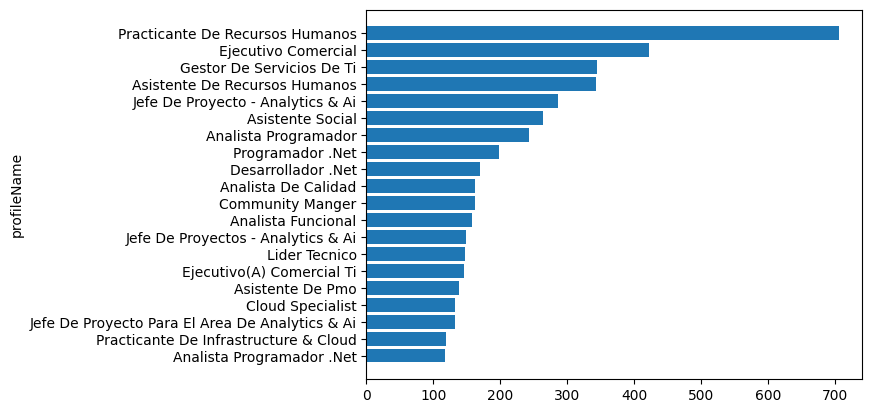

Peru                    8614
Venezuela                137
Argentina                 11
Colombia                   7
Brasil                     4
Ecuador                    3
Republica Dominicana       1
Francia                    1
Bolivia                    1
Costa Rica                 1
Chile                      1
Espana                     1
Panama                     1
El Salvador                1
Name: residenceCountry, dtype: int64


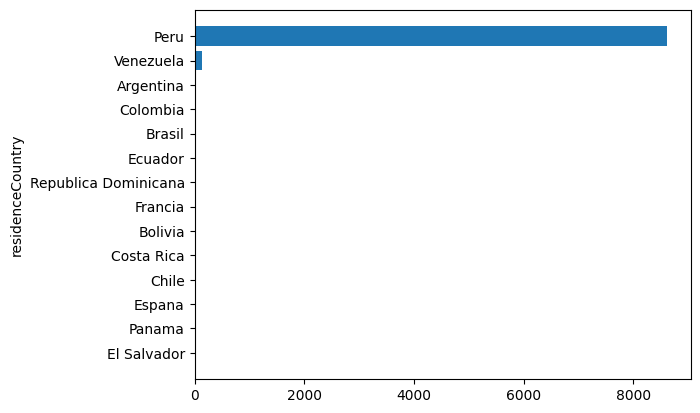

Canvia                                      117
Freelance (Clientes)                         78
Everis                                       53
Global Hitss                                 52
Independiente                                52
Mdp Consulting                               49
Indra                                        43
Banco De Credito Del Peru                    36
Everis Peru Sac                              32
Tata Consultancy Services                    29
Experis                                      25
Pontificia Universidad Catolica Del Peru     22
Telefonica Del Peru                          22
Universidad Privada Del Norte                22
Mdp                                          22
Tivit                                        22
Tgestiona                                    22
Farmacias Peruanas                           21
Interbank                                    21
Everis Peru                                  20
Name: lastWorkCenter, dtype: int64


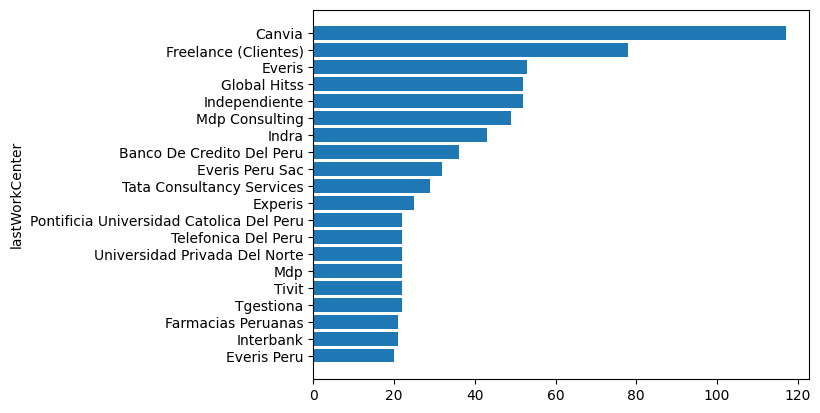

Analista Programador                            354
Analista De Sistemas                            159
Analista Funcional                               93
Jefe De Proyectos                                80
Supervisor De Infraestructura De Redes Cisco     78
Trabajadora Social                               77
Asistente Administrativo                         60
Asesor Comercial                                 53
Project Manager                                  53
Ejecutivo Comercial                              49
Asistente De Recursos Humanos                    49
Analista De Sistemas Senior                      45
Analista                                         43
Practicante                                      43
Key Account Manager                              37
Jefe De Sistemas                                 37
Programador                                      34
Asistente                                        33
Soporte Tecnico                                  33
Lider Tecnic

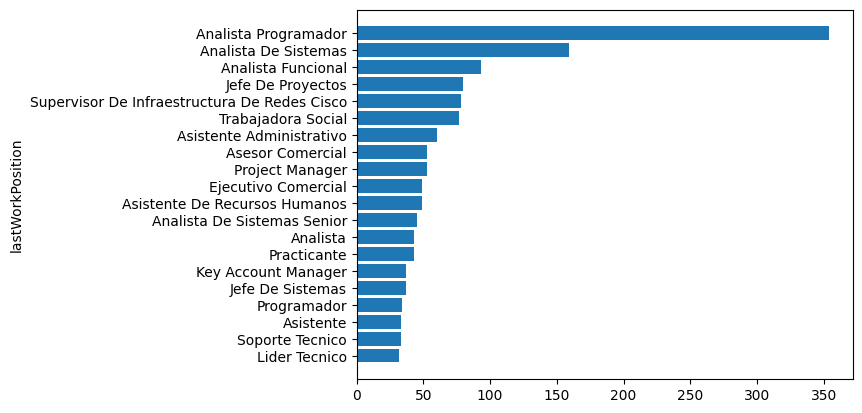

4     692
5     651
8     625
6     611
7     606
3     565
2     558
1     555
0     493
9     488
10    463
11    401
12    285
13    276
15    241
14    229
16    164
17    115
19    109
20    101
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


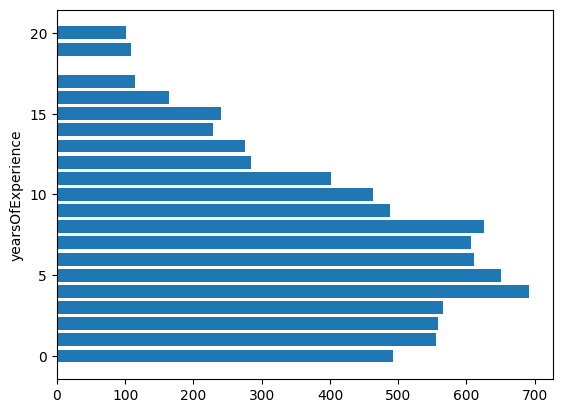

5     1206
4     1095
6      977
3      910
7      877
8      676
2      643
1      515
9      487
10     383
11     249
12     228
13     142
14     113
15      89
17      50
16      41
19      37
18      25
20      13
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


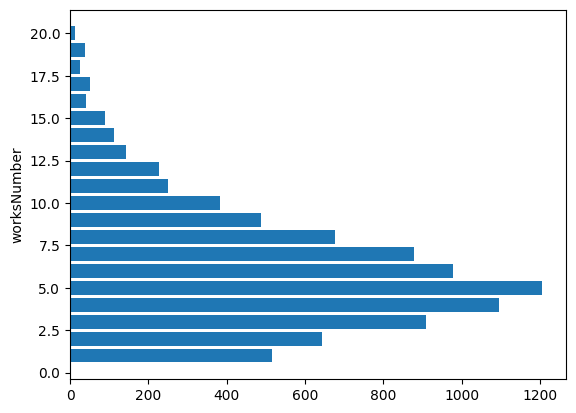

Universidad Peruana De Ciencias Aplicadas    472
Universidad Tecnologica Del Peru             295
Pontificia Universidad Catolica Del Peru     281
Upc                                          255
Universidad Nacional Mayor De San Marcos     249
Universidad Privada Del Norte                247
Universidad Esan                             222
Cibertec                                     189
Instituto Cibertec                           183
Universidad Cesar Vallejo                    177
Universidad De Lima                          171
Universidad Nacional De Ingenieria           165
Universidad Inca Garcilaso De La Vega        163
Universidad Ricardo Palma                    163
Universidad Nacional Federico Villarreal     157
Universidad De San Martin De Porres          157
Isil                                         145
Utp                                          135
Universidad San Ignacio De Loyola            124
Tecsup                                       118
Name: studyCenter, d

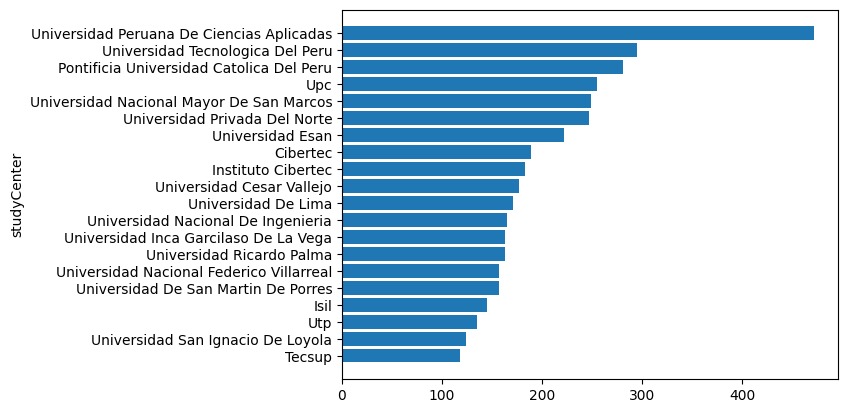

Ing. En Sistemas                  1961
Tecnologias De La Informacion     1163
Adm. De Empresas                  1024
Ing. Informatica                   524
Ing. Industrial                    405
Computacion / Informatica          390
Marketing / Comercializacion       345
Recursos Humanos / Relac. Ind.     329
Otra                               322
Psicologia                         260
Ing. - Otros                       163
Trabajo Social                     131
Analisis De Sistemas               117
Telecomunicaciones                 110
Ing. Telecomunicaciones            105
Programacion                       105
Finanzas                            93
Procesos / Calidad Total            89
Bachiller                           81
Ing. Electronica                    68
Name: careerField, dtype: int64


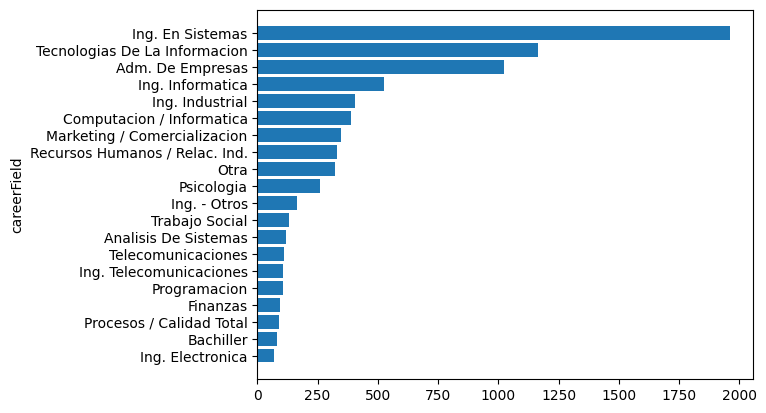

Graduado      5942
En Curso      2704
Abandonado     134
                 4
Name: careerStatus, dtype: int64


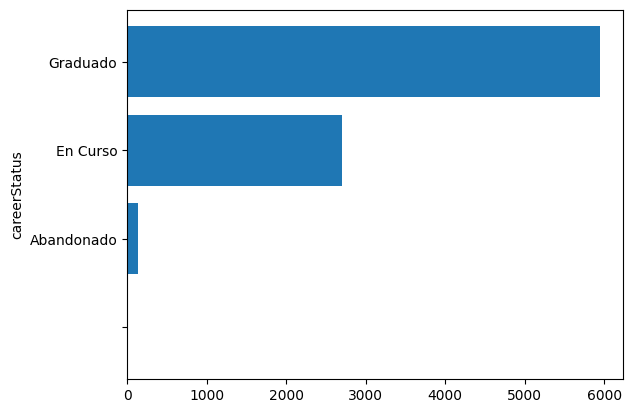

Universitario        4146
Otro                 2081
Posgrado             1124
Terciario/Tecnico     847
Master                564
Doctorado              13
Secundario              6
                        3
Name: careerDegree, dtype: int64


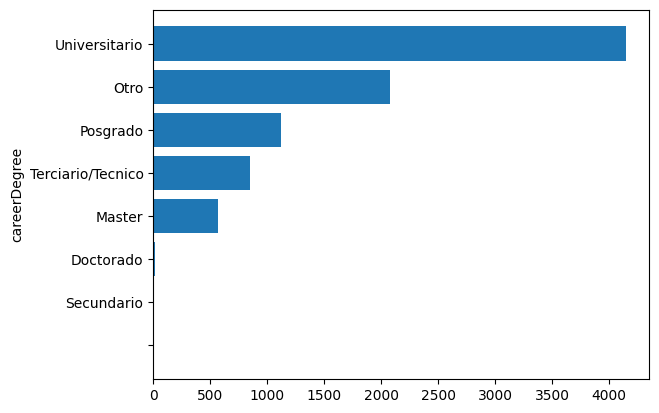

1     3000
2     2125
3     1094
4      653
5      421
6      394
7      280
8      173
9      136
11     112
10      88
12      66
14      48
13      40
16      24
15      20
20      18
18      16
17      15
19      14
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


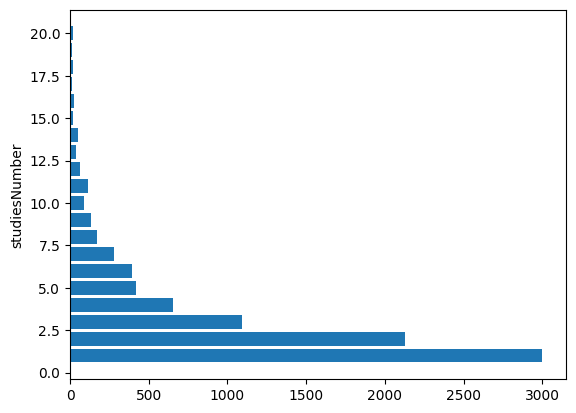

1     988
0     871
3     737
2     703
4     574
5     503
6     433
7     419
9     400
8     366
11    300
10    299
12    238
13    216
16    207
14    162
15    147
18    112
17    109
21     84
Name: technicalSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


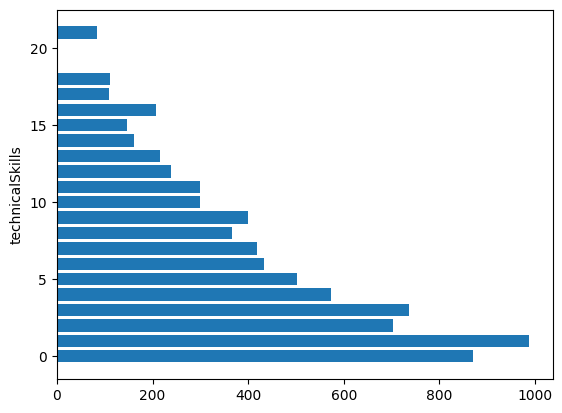

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


1    6804
2    1651
3     245
4      54
0      28
5       2
Name: languages, dtype: int64


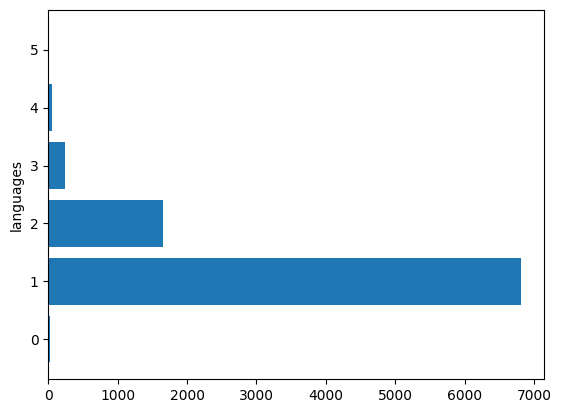

0     1815
1     1506
2     1035
3      730
4      661
5      588
6      442
7      379
8      308
9      243
10     195
11     158
12     131
13     102
14      81
15      66
17      45
16      43
20      35
19      27
Name: anotherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


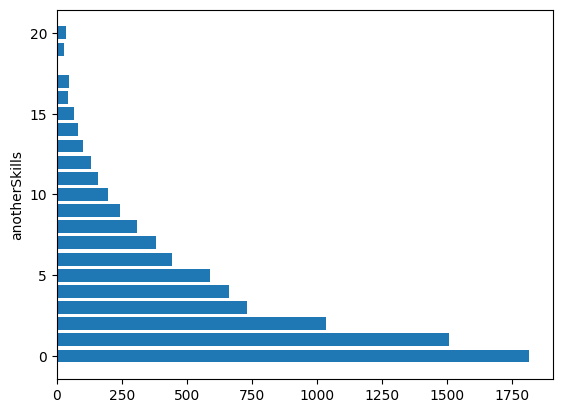

2500    560
5000    560
2000    538
3500    523
3000    514
4000    485
1500    423
6000    419
4500    376
1800    337
1200    290
5500    282
7000    258
6500    257
1000    222
1025    197
1       193
8000    188
930     174
7500    124
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_13592\515460235.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = df[column].value_counts()[:dataVisualizationTopLimit]


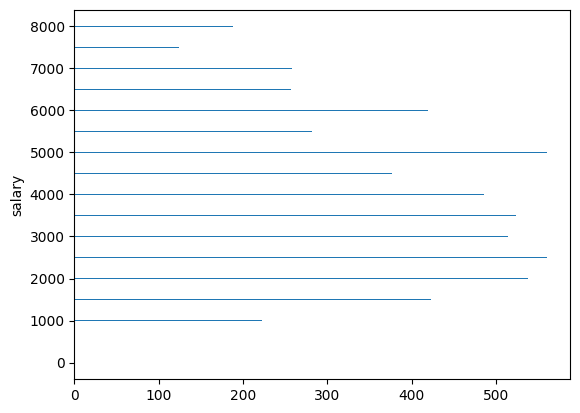

Fin: 2023-05-11 11:19:24.092379
Tiempo: 0:01:58.549241


In [182]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = False
  isLoadedLinkedin = True
  isMergedMain = False
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Leyendo o calculando linkedin
  linkedinData = readJson(os.path.join(intermFilesFolder, 'linkedin.json')) if isLoadedLinkedin else readAndWriteMain('linkedin')
  print("Se terminó de procesar Linkedin")

  # Uniendo la data principal (bumeran + linkedin)
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData, linkedinData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

  #print(counterIn)
  #print(counterOut)

if __name__ == "__main__":
  main()